Dataset: **Montreal Archive of Sleep Studies** (MASS) 
http://ceams-carsm.ca/mass/

In [1]:
# !pip install mne pyedflib seglearn tsfel tsfresh antropy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../ML_tools/src/")

sys.path.append("../src/")

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly_resampler import FigureResampler

## Download the data

In order to access the data you should submit a request as is described here; http://ceams-carsm.ca/mass/ 

# Create dataloader

## Some EDF loading funcs

In [5]:
from data import load_signals, load_annotations, annotation_to_30s_labels

## Load some data

In [6]:
data_folder = "../../../../data/sleep/MASSDB/"

os.listdir(data_folder)

['SS3_EDF_part2',
 'SS3_EDF_part1',
 'SS5_EDF.zip',
 'SS1_Annotations',
 'SS1_EDF_1_30.zip',
 'SS1_EDF_part2.zip',
 'SS5_Annotations',
 'SS4_Annotations',
 'SS2_Annotations',
 'SS3_Annotations',
 'SS2_EDF_part1.zip',
 'SS4_EDF_part1.zip']

In [7]:
os.listdir(data_folder + "SS3_EDF_part1")[:10]

['01-03-0021 PSG.edf',
 '01-03-0006 Base.edf',
 '01-03-0006 PSG.edf',
 '01-03-0025 Base.edf',
 '01-03-0009 PSG.edf',
 '01-03-0007 PSG.edf',
 '01-03-0024 PSG.edf',
 '01-03-0030 PSG.edf',
 '01-03-0032 Base.edf',
 '01-03-0024 Base.edf']

In [8]:
len(os.listdir(data_folder + "SS3_EDF_part1"))

70

In [9]:
!du -hs ../../../../data/sleep/MASSDB/SS3_EDF_part1

13G	../../../../data/sleep/MASSDB/SS3_EDF_part1


=> In total 70 files (35 PSG files - 35 hypnogram files) => 13 GB

In [10]:
os.listdir(data_folder + "SS3_EDF_part2")[:10]

['01-03-0047 Base.edf',
 '01-03-0062 PSG.edf',
 '01-03-0039 Base.edf',
 '01-03-0048 PSG.edf',
 '01-03-0036 Base.edf',
 '01-03-0053 Base.edf',
 '01-03-0037 Base.edf',
 '01-03-0053 PSG.edf',
 '01-03-0061 Base.edf',
 '01-03-0064 PSG.edf']

In [11]:
len(os.listdir(data_folder + "SS3_EDF_part2"))

54

In [12]:
!du -hs ../../../../data/sleep/MASSDB/SS3_EDF_part2

12G	../../../../data/sleep/MASSDB/SS3_EDF_part2


=> In total 54 files (27 PSG files - 27 hypnogram files) => 12 GB

In [13]:
dfs = []
sub_folders = ["SS3_EDF_part1", "SS3_EDF_part2"]
for sub_folder in sub_folders:
    sorted_files = sorted(os.listdir(data_folder + sub_folder))
    psg_hypnogram_files = [(h, p) for p, h in zip(sorted_files[::2], sorted_files[1:][::2])]
    df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
    df_files["subfolder"] = sub_folder
    dfs += [df_files]
    
df_files = pd.concat(dfs)
    
# Because for the SC study patients were monitored for 2 consecutive nights
df_files["patient_id"] = df_files.psg_file.apply(lambda f: f.split(" ")[0])
df_files

,psg_file,label_file,subfolder,patient_id
0,01-03-0001 PSG.edf,01-03-0001 Base.edf,SS3_EDF_part1,01-03-0001
1,01-03-0002 PSG.edf,01-03-0002 Base.edf,SS3_EDF_part1,01-03-0002
2,01-03-0003 PSG.edf,01-03-0003 Base.edf,SS3_EDF_part1,01-03-0003
3,01-03-0004 PSG.edf,01-03-0004 Base.edf,SS3_EDF_part1,01-03-0004
4,01-03-0005 PSG.edf,01-03-0005 Base.edf,SS3_EDF_part1,01-03-0005
...,...,...,...,...
22,01-03-0060 PSG.edf,01-03-0060 Base.edf,SS3_EDF_part2,01-03-0060
23,01-03-0061 PSG.edf,01-03-0061 Base.edf,SS3_EDF_part2,01-03-0061
24,01-03-0062 PSG.edf,01-03-0062 Base.edf,SS3_EDF_part2,01-03-0062
25,01-03-0063 PSG.edf,01-03-0063 Base.edf,SS3_EDF_part2,01-03-0063


In [14]:
df_files.psg_file.nunique()

62

In [15]:
df_files.patient_id.nunique()

62

=> psg file can be used as recordingid   
=> patient id can be used as patient id 

In [16]:
signal_dict = {}

for idx in range(len(df_files)):
    sig, freq = load_signals(data_folder + df_files.iloc[idx].subfolder + "/" + df_files.iloc[idx].psg_file, only_info=True)
    for s, f in zip(sig, freq):
        if (s,f) in signal_dict.keys():
            signal_dict[(s,f)].append(idx)
        else:
            signal_dict[(s,f)] = [idx]
            
sorted([(k, len(v)) for k, v in signal_dict.items()])

[(('ECG ECGI', 256), 43),
 (('ECG ECGI', 512), 19),
 (('EEG A2-LER', 256), 43),
 (('EEG C3-LER', 256), 62),
 (('EEG C4-LER', 256), 62),
 (('EEG Cz-LER', 256), 62),
 (('EEG F3-LER', 256), 62),
 (('EEG F4-LER', 256), 62),
 (('EEG F7-LER', 256), 62),
 (('EEG F8-LER', 256), 62),
 (('EEG Fp1-LER', 256), 62),
 (('EEG Fp2-LER', 256), 62),
 (('EEG Fz-LER', 256), 62),
 (('EEG O1-LER', 256), 62),
 (('EEG O2-LER', 256), 62),
 (('EEG Oz-LER', 256), 62),
 (('EEG P3-LER', 256), 62),
 (('EEG P4-LER', 256), 62),
 (('EEG Pz-LER', 256), 62),
 (('EEG T3-LER', 256), 62),
 (('EEG T4-LER', 256), 62),
 (('EEG T5-LER', 256), 62),
 (('EEG T6-LER', 256), 62),
 (('EMG Chin1', 128), 43),
 (('EMG Chin1', 256), 19),
 (('EMG Chin2', 128), 43),
 (('EMG Chin2', 256), 19),
 (('EMG Chin3', 128), 43),
 (('EMG Chin3', 256), 19),
 (('EOG Left Horiz', 256), 62),
 (('EOG Right Horiz', 256), 62),
 (('Resp Belt Abdo', 64), 19),
 (('Resp Belt Thor', 64), 19)]

In [17]:
common_signals = [
    'EOG Left Horiz', 'EOG Right Horiz',  # All have the same sampling rate (100 Hz)
    'EEG C3-LER', 'EEG A2-LER', 'EEG F4-LER', 'EEG F8-LER', 'EEG Cz-LER', #'EEG P4-LER',
    # 'EEG Cz-LER', 'EEG Pz-LER', 'EEG Oz-LER',
    'EMG Chin1', 'EMG Chin2', #'EMG Chin3',  # Different sampling rate: 100 Hz for telemetry & 1 Hz for cassette
]

common_signals = [
    'EOG Left Horiz', 'EOG Right Horiz',  # All have the same sampling rate (100 Hz)
    'EEG C4-LER', 'EEG O1-LER', 'EEG F4-LER', 'EEG F8-LER', 'EEG Cz-LER', #'EEG P4-LER',
    # 'EEG Cz-LER', 'EEG Pz-LER', 'EEG Oz-LER',
    'EMG Chin1', 'EMG Chin2', #'EMG Chin3',  # Different sampling rate: 100 Hz for telemetry & 1 Hz for cassette
]

In [18]:
data = load_signals(data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file, retrieve_signals=common_signals + ['ECG ECGI'])
annotations = load_annotations(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].label_file,
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file
)

In [19]:
# Used for plotting
cats = [
    "Sleep stage ?",
    "Movement time",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
][::-1]


# EDA + pipeline (for 1 patient)

In [20]:
idxs = ["EOG", "EEG", "EMG"]

fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1 + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs + ["ECG"] + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=2_000,
)


for s in data:
    if "ECG" in s.name:
        fig.add_trace(
            go.Scattergl(
                x=[], y=[], name="ECG", line_width=1
            ),
            hf_x=s.index,
            hf_y=s.values,
            row=len(idxs) + 1,
            col=1,
        )

    try:
        idx = idxs.index(s.name.split(" ")[0]) + 1
    except:
        continue
    fig.add_trace(
        go.Scattergl(
            x=[], y=[], name=s.name, line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.add_trace(
    go.Scattergl(
        x=[], y=[], name="Hypnogram", line_width=1.5, line_shape="hv",
    ),
    hf_x=annotation_to_30s_labels(annotations).index,
    hf_y=annotation_to_30s_labels(annotations)["label"].values,
    row=len(idxs) + 2,
    col=1,
)

fig.update_layout(height=900)
fig.update_yaxes(categoryorder="array", categoryarray=cats)

fig.update_layout(
    legend_traceorder="normal",
    template="plotly_white",
    #     legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8042)

Dash app running on http://127.0.0.1:8042/


## Process the signals

In [21]:
## Processing
from scipy.signal import butter, lfilter, iirnotch

from tsflex.processing import SeriesPipeline, SeriesProcessor

def determine_fs(sig):
    return int(10**9 / data[0].index.to_series().diff().median().to_timedelta64().astype(float))

def butter_bandpass_filter(sig, lowcut, highcut, fs=None, order=5):
    if fs is None:
        fs = determine_fs(sig)
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y

def resample(sig, fs):
    return sig.resample(pd.Timedelta(10**3/fs, unit="ms")).mean().interpolate()

def create_montage(sig1, sig2):
    return (sig1 - sig2).rename(sig1.name + " - " + sig2.name)

def average(sig1, sig2):
    return (sig1 + sig2).rename(sig1.name + "_" + sig2.name + "_[AVG]") / 2

eeg_signals = [s for s in common_signals if s.startswith("EEG")]
eog_signals = [s for s in common_signals if s.startswith("EOG")]
emg_signals = [s for s in common_signals if s.startswith("EMG")]

eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=eeg_signals + eog_signals,
    lowcut=0.4,
    highcut=30,
    fs=256,
)

emg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=emg_signals,
    lowcut=0.5,
    highcut=10,
)

## OG pipeline
process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
        emg_bandpass,
        SeriesProcessor(resample, series_names=common_signals, fs=100),
        SeriesProcessor(
            create_montage, 
            series_names=[("EEG C4-LER", "EEG O1-LER"), ("EEG F4-LER", "EOG Left Horiz")],#, ("EEG F8-LER", "EEG Cz-LER")]
        ),
        SeriesProcessor(
            average,
            series_names=[("EOG Left Horiz", "EOG Right Horiz"), ("EMG Chin1", "EMG Chin2")]
        ),
        # emg_bandpass,
    ]
)

out_signals = ['EEG C4-LER - EEG O1-LER',
#  'EEG F8-LER - EEG Cz-LER',
 'EEG F4-LER - EOG Left Horiz',
 'EOG Left Horiz_EOG Right Horiz_[AVG]',
 'EMG Chin1_EMG Chin2_[AVG]']

process_pipe = SeriesPipeline(
    [        
        eeg_bandpass,
        emg_bandpass,
        SeriesProcessor(
            average,
            series_names=[("EOG Left Horiz", "EOG Right Horiz"), ("EMG Chin1", "EMG Chin2")]
        ),
        SeriesProcessor(
            create_montage, 
            series_names=[("EEG C4-LER", "EEG O1-LER"), ("EEG F4-LER", "EOG Left Horiz")]#, ("EEG F8-LER", "EEG Cz-LER")]
        ),
        SeriesProcessor(resample, series_names=out_signals, fs=100),
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 256} :  ('EEG C4-LER',) ('EEG O1-LER',) ('EEG F4-LER',) ('EEG F8-LER',) ('EEG Cz-LER',) ('EOG Left Horiz',) ('EOG Right Horiz',)
	butter_bandpass_filter {'lowcut': 0.5, 'highcut': 10} :  ('EMG Chin1',) ('EMG Chin2',)
	average {} :  ('EOG Left Horiz', 'EOG Right Horiz') ('EMG Chin1', 'EMG Chin2')
	create_montage {} :  ('EEG C4-LER', 'EEG O1-LER') ('EEG F4-LER', 'EOG Left Horiz')
	resample {'fs': 100} :  ('EEG C4-LER - EEG O1-LER',) ('EEG F4-LER - EOG Left Horiz',) ('EOG Left Horiz_EOG Right Horiz_[AVG]',) ('EMG Chin1_EMG Chin2_[AVG]',)
]

In [22]:
%%time
data_processed = process_pipe.process(data, return_all_series=False, drop_keys=eeg_signals + eog_signals + emg_signals)
# data_processed = process_pipe.process(data, return_all_series=False)#, drop_keys=eeg_signals + eog_signals + emg_signals)

CPU times: user 2.28 s, sys: 674 ms, total: 2.95 s
Wall time: 2.92 s


In [23]:
for s in data_processed:
    idx = idxs.index(s.name.split(" ")[0]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )
    
fig.show_dash(port=8042)

Dash app running on http://127.0.0.1:8042/


## Extract the features

In [24]:
eeg_cols = [s.name for s in data_processed if s.name.startswith("EEG")]
eog_cols = [s.name for s in data_processed if s.name.startswith("EOG")]
emg_cols = [s.name for s in data_processed if s.name.startswith("EMG")]
print(eeg_cols)
print(eog_cols)
print(emg_cols)

['EEG F4-LER - EOG Left Horiz', 'EEG C4-LER - EEG O1-LER']
['EOG Left Horiz_EOG Right Horiz_[AVG]']
['EMG Chin1_EMG Chin2_[AVG]']


In [25]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings

{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [26]:
import antropy as ant
import scipy.stats as ss
from yasa import bandpower

import scipy.stats as ss
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x):
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs, eeg_cols + eog_cols + emg_cols,
    windows=["30s", "60s", "90s"], strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs, eeg_cols + eog_cols,
    windows=["30s", "60s", "90s"], strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats])
# fc

In [27]:
import logging 

from tsflex.features.logger import logger
logger.setLevel(level=logging.ERROR)

from tsflex.processing.logger import logger
logger.setLevel(level=logging.ERROR)

In [28]:
# %%time
feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
feats

  0%|          | 0/261 [00:00<?, ?it/s]

,EEG C4-LER - EEG O1-LER__TotalAbsPow__w=1m30s_s=30s,EEG C4-LER - EEG O1-LER__TotalAbsPow__w=1m_s=30s,EEG C4-LER - EEG O1-LER__TotalAbsPow__w=30s_s=30s,EEG C4-LER - EEG O1-LER__alpha__w=1m30s_s=30s,EEG C4-LER - EEG O1-LER__alpha__w=1m_s=30s,EEG C4-LER - EEG O1-LER__alpha__w=30s_s=30s,EEG C4-LER - EEG O1-LER__beta__w=1m30s_s=30s,EEG C4-LER - EEG O1-LER__beta__w=1m_s=30s,EEG C4-LER - EEG O1-LER__beta__w=30s_s=30s,EEG C4-LER - EEG O1-LER__binned_entropy_{'max_bins': 10}__w=1m30s_s=30s,...,EOG Left Horiz_EOG Right Horiz_[AVG]__skew__w=30s_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__std__w=1m30s_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__std__w=1m_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__std__w=30s_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__theta__w=1m30s_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__theta__w=1m_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__theta__w=30s_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__wrapped_higuchi_fd__w=1m30s_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__wrapped_higuchi_fd__w=1m_s=30s,EOG Left Horiz_EOG Right Horiz_[AVG]__wrapped_higuchi_fd__w=30s_s=30s
2000-01-01 21:28:23,NaN,NaN,42.457673,NaN,NaN,0.147711,NaN,NaN,0.060797,NaN,...,-1.300548,NaN,NaN,9.632114,NaN,NaN,0.089987,NaN,NaN,1.622883
2000-01-01 21:28:53,NaN,38.621956,38.987855,NaN,0.109785,0.074727,NaN,0.05605,0.04344,NaN,...,-0.236141,NaN,12.814378,15.328005,NaN,0.073491,0.045014,NaN,1.537349,1.450732
2000-01-01 21:29:23,35.66086,32.425519,44.962163,0.168682,0.18713,0.458264,0.05987,0.057253,0.05073,1.076488,...,0.119529,14.119242,15.891333,16.412610,0.063796,0.051673,0.067629,1.513740,1.457032,1.467876
2000-01-01 21:29:53,29.378379,32.836996,27.899303,0.218926,0.316914,0.221476,0.065742,0.065687,0.072345,1.055687,...,-0.123054,13.155476,11.906914,3.754816,0.076116,0.075971,0.090717,1.513196,1.553211,1.676340
2000-01-01 21:30:23,27.176844,23.646118,18.956875,0.237448,0.17418,0.147383,0.068801,0.06996,0.072987,1.690932,...,0.440301,10.440067,5.362053,6.588197,0.089699,0.107171,0.102644,1.547175,1.605256,1.532670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-01-02 05:59:53,67.457257,65.833353,55.544329,0.070965,0.080932,0.088443,0.019352,0.019928,0.029542,1.642027,...,-0.057074,6.756273,6.074860,6.215825,0.139421,0.152136,0.187128,1.410516,1.433275,1.476446
2000-01-02 06:00:23,78.736117,83.661787,151.995921,0.089132,0.089835,0.084587,0.022012,0.028249,0.061087,0.507468,...,0.278932,61.811473,75.587059,106.715272,0.136022,0.134824,0.032963,1.270499,1.259598,1.234685
2000-01-02 06:00:53,72.088155,92.1134,63.986004,0.110996,0.11289,0.135875,0.045194,0.099761,0.147312,0.517686,...,0.861418,67.744800,82.853550,48.386638,0.070451,0.057948,0.068542,1.297602,1.284611,1.376458
2000-01-02 06:01:23,116.554523,94.892555,285.597411,0.077191,0.072359,0.020969,0.11665,0.146382,0.07232,0.710774,...,0.614399,80.366705,63.199168,75.146153,0.085664,0.092577,0.083237,1.290983,1.331246,1.304121


# Pipeline for all patients

In [39]:
from tqdm.auto import tqdm

def slice_data(series_list, start):
    return [s[s.index >= start] for s in series_list]

df_feats = []
for sub_folder, psg_file, hypnogram_file in tqdm(zip(df_files.subfolder, df_files.psg_file, df_files.label_file)):
    file_folder = data_folder + sub_folder + "/"
    # Load the annotations
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    start_idx = annotations.index.values[0]
    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file, retrieve_signals=common_signals)
    data_processed = process_pipe.process(data, drop_keys=eeg_signals + eog_signals + emg_signals)
    df_feat = feature_collection.calculate(
        slice_data(data_processed, start_idx), return_df=True, window_idx="begin"
    ).astype("float32")
    # Add the labels (and reduce features to only data for which we have labels)
    df_feat = pd.merge_asof(df_feat, annotations, left_index=True, right_index=True, tolerance=pd.Timedelta(0.05, unit="s"), direction="nearest")
    # Add the file name & folder
    df_feat["psg_file"] = psg_file
    df_feat["patient_id"] = psg_file.split(" ")[0]
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

0it [00:00, ?it/s]

In [40]:
df_feats.to_parquet("../features/mass_SS3_features_ALL__ext.parquet")

## Load data

In [28]:
df_feats = pd.read_parquet("../features/mass_SS3_features_ALL__ext.parquet")
df_feats.shape

(62767, 366)

In [29]:
df_feats["label"].value_counts()

Sleep stage 2    29802
Sleep stage R    10581
Sleep stage 3     7653
Sleep stage W     6442
Sleep stage 1     4839
Sleep stage ?     3448
Name: label, dtype: int64

In [30]:
df_feats[~df_feats.psg_file.isin(df_files.psg_file.unique())].psg_file.nunique()

0

In [31]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62767 entries, 2000-01-01 21:28:00.010000 to 2000-01-02 07:14:30.010000
Columns: 366 entries, EEG C4-LER - EEG O1-LER__TotalAbsPow__w=1m30s_s=30s to patient_id
dtypes: float32(363), object(3)
memory usage: 88.8+ MB


In [32]:
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_cols:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats.shape

(62767, 396)

In [33]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [34]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if "w=1m_" in f]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(2).add_suffix("_shift=1m"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.merge(
        sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"),
        left_index=True,
        right_index=True,
    )

    # sub_df = sub_df.merge(sub_df[feats_2m].shift(8).add_suffix("_shift=4m"), left_index=True, right_index=True)
    # sub_df = sub_df.merge(sub_df[feats_1m].shift(4).add_suffix("_shift=2m"), left_index=True, right_index=True)
    # sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    # sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    # sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    # sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    # sub_df = sub_df.merge(sub_df[feats_1m].shift(-4).add_suffix("_shift=-2m"), left_index=True, right_index=True)
    # sub_df = sub_df.merge(sub_df[feats_2m].shift(-8).add_suffix("_shift=-4m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

131 131 131


(62767, 1051)

In [35]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62767 entries, 2000-01-01 21:28:00.010000 to 2000-01-02 07:14:30.010000
Columns: 1051 entries, EEG C4-LER - EEG O1-LER__TotalAbsPow__w=1m_s=30s to EEG C4-LER - EEG O1-LER__delta/theta__w=30s_s=30s_shift=-1m
dtypes: float32(1048), object(3)
memory usage: 252.8+ MB


In [36]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats.loc[df_feats["label"] == "Movement time", "label"] = "Sleep stage W"
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_feats = df_feats[~df_feats["label"].isna()]

In [37]:
df_feats.shape

(59317, 1051)

### Look into nan features

In [38]:
no_shift_cols = [c for c in df_feats.columns if not "shift=" in c]# or "w=1m" in c or "w=1m30s" in c]
len(no_shift_cols)

265

In [39]:
normal_nan_mask = (df_feats[no_shift_cols].isna().sum() / df_feats.psg_file.nunique()).isin([0, 1, 2])
df_feats[np.array(no_shift_cols)[~normal_nan_mask]].isna().sum().sort_values()[::-1]

EEG C4-LER - EEG O1-LER__delta/theta__w=1m_s=30s                                     15
EEG F4-LER - EOG Left Horiz__TotalAbsPow__w=1m_s=30s                                 15
EEG F4-LER - EOG Left Horiz__beta__w=1m_s=30s                                        15
EEG F4-LER - EOG Left Horiz__binned_entropy_{'max_bins': 10}__w=1m_s=30s             15
EEG F4-LER - EOG Left Horiz__binned_entropy_{'max_bins': 30}__w=1m_s=30s             15
                                                                                     ..
EOG Left Horiz_EOG Right Horiz_[AVG]__binned_entropy_{'max_bins': 10}__w=1m_s=30s    15
EOG Left Horiz_EOG Right Horiz_[AVG]__binned_entropy_{'max_bins': 30}__w=1m_s=30s    15
EOG Left Horiz_EOG Right Horiz_[AVG]__binned_entropy_{'max_bins': 5}__w=1m_s=30s     15
EOG Left Horiz_EOG Right Horiz_[AVG]__binned_entropy_{'max_bins': 60}__w=1m_s=30s    15
EEG C4-LER - EEG O1-LER__TotalAbsPow__w=1m_s=30s                                     15
Length: 131, dtype: int64

In [40]:
for psg_file in df_feats.psg_file.unique():
    assert not df_feats[df_feats.psg_file == psg_file].isna().any(axis=1)[2:-2].any()

In [41]:
df_feats[np.array(no_shift_cols)[~normal_nan_mask]].isna().any(axis=1).sum() / len(df_feats)

0.00025287860141274843

=> 0.025% of the feature vectors contain some nan value

*Further findings*: more in depth analysis revealed that the nan values are only present at the start and end of the file (in the first two and last two epochs -> when there is not enough data to calculate a larger window features (90s, 60s)).

**What to do with this?**  
For the sake of simplicity we will keep those feature vectors and just (simply) impute the nan values as
* only 0.025% of the feature vectors (i.e., samples) is affected -> will have minimal / no impact on results
* these samples ara at the start & end of the recording and are most likely thus wake (and rather easy to predict from the other samples)

## EDA on labels

<AxesSubplot:>

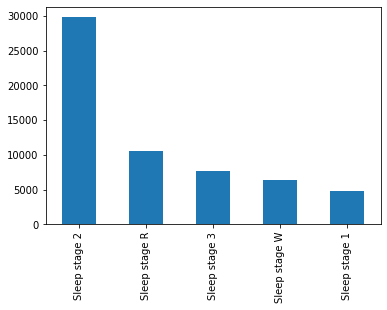

In [42]:
df_feats["label"].value_counts().plot(kind="bar")

In [43]:
df_feats["label"].value_counts()

Sleep stage 2    29802
Sleep stage R    10581
Sleep stage 3     7653
Sleep stage W     6442
Sleep stage 1     4839
Name: label, dtype: int64

=> There is quite some label imbalance

## EDA on features

In [44]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [45]:
import math

import matplotlib.pyplot as plt

plot_cols = [c for c in feat_cols if not "_shift=" in c]

# n_cols = 10
# n_rows = math.ceil(len(plot_cols) / n_cols)
# plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

# for idx, col in enumerate(plot_cols):
#     plt.subplot(n_rows, n_cols, idx + 1)
#     plt.boxplot(df_feats[col].dropna(), vert=True)
#     plt.xlabel(col)

# plt.tight_layout()
# plt.show()

# ML

In [46]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier

In [47]:
from ml_tools.visualizations.models_linear import plot_linear_classification_coefs
from ml_tools.visualizations.models import plot_learning_curve
from ml_tools.visualizations.evaluation import plot_confusion_matrix

## The simple, linear pipeline

In [48]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer(n_quantiles=100, subsample=200_000, random_state=0)),
        (
            "linear_model",
            SGDClassifier(
                loss="log",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

### Grouped 10-fold results for all the data

In [53]:
# Total of 10 folds
gkfold = StratifiedGroupKFold(n_splits=10)
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.psg_file)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [54]:
print("20-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

20-FOLD: TRAIN
  MACRO F1:           0.83
  Balanced accuracy:  0.8393
  Accuracy:           0.8712
  Log loss:           0.5598


In [55]:
print("20-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


20-FOLD: TEST
  MACRO F1:           0.8047
  Balanced accuracy:  0.8143
  Accuracy:           0.8525
  Log loss:           0.706


In [56]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [57]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8066796509778678
ACC: 0.8527066439637878
KAPPA: 0.7857701838079729
LOG LOSS: 0.7064492700020433


In [58]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.55      0.56      0.56      4745
Sleep stage 2       0.88      0.91      0.89     28683
Sleep stage 3       0.89      0.80      0.84      8481
Sleep stage R       0.87      0.86      0.87     10762
Sleep stage W       0.89      0.86      0.87      6646

     accuracy                           0.85     59317
    macro avg       0.82      0.80      0.81     59317
 weighted avg       0.85      0.85      0.85     59317



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

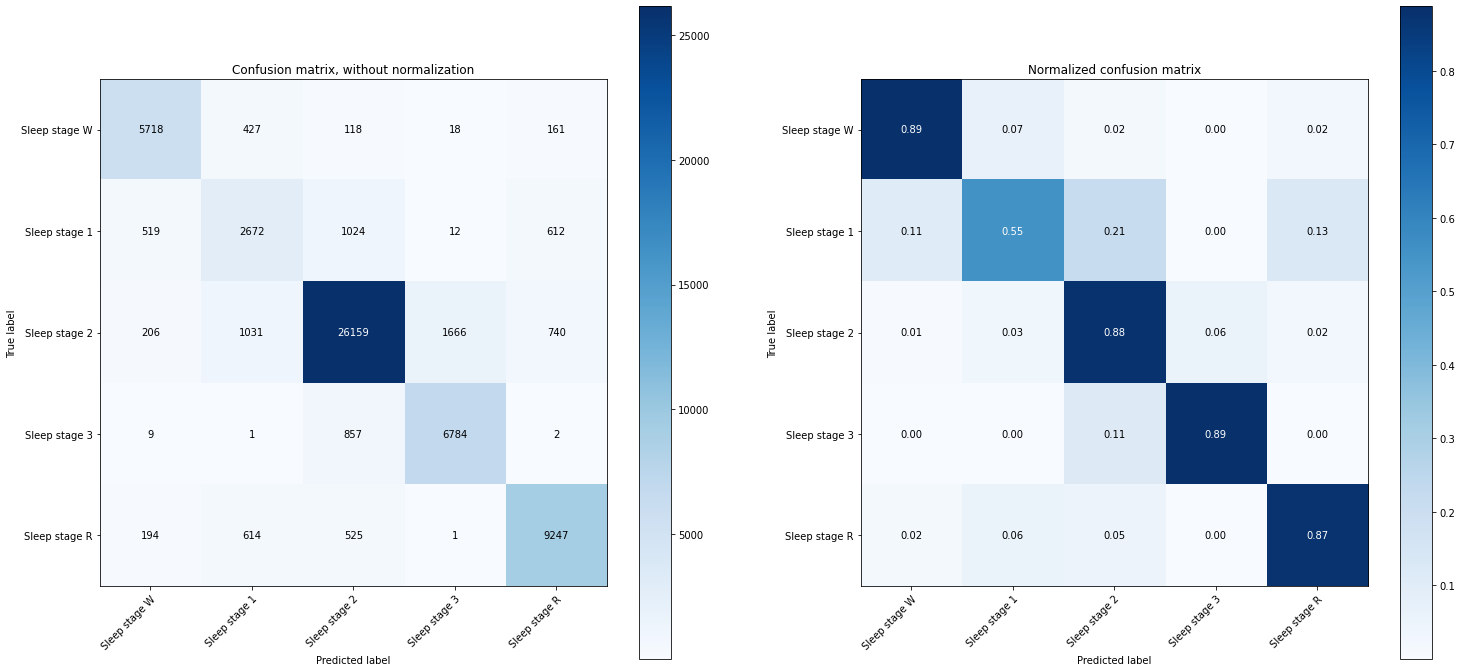

In [59]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

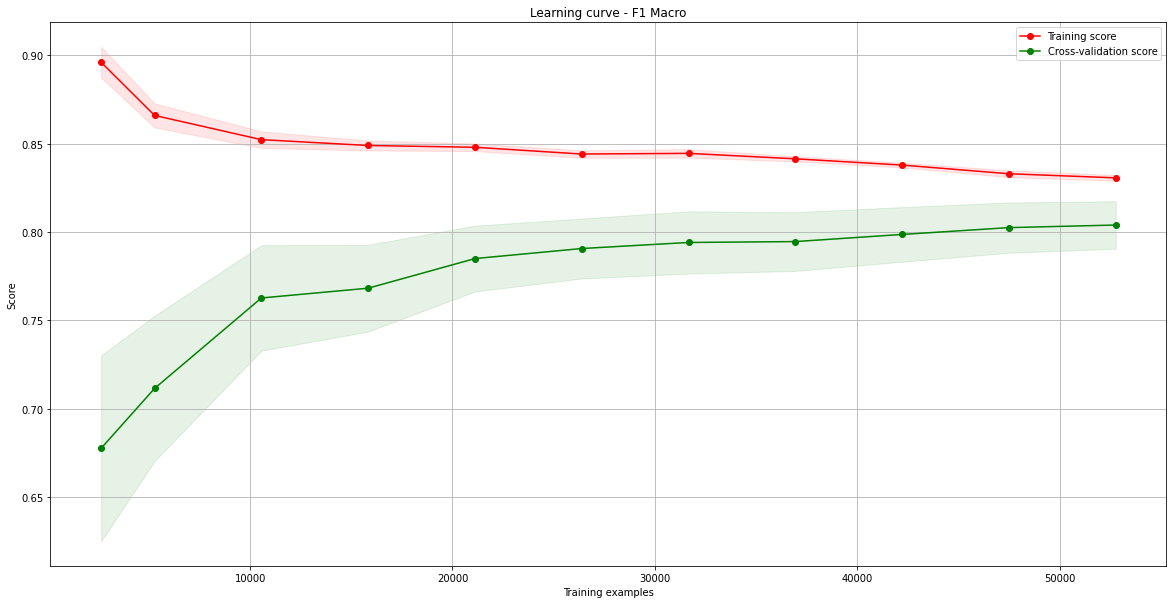

In [74]:
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.psg_file)
_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats[feat_cols],
    y=df_feats["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=20,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)


### Grouped X-fold results for all the data

In [60]:
# Total of 31 folds
gkfold = StratifiedGroupKFold(n_splits=31)
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.psg_file)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [61]:
print("31-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

31-FOLD: TRAIN
  MACRO F1:           0.8289
  Balanced accuracy:  0.839
  Accuracy:           0.8701
  Log loss:           0.5431


In [62]:
print("31-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


31-FOLD: TEST
  MACRO F1:           0.7983
  Balanced accuracy:  0.8111
  Accuracy:           0.8522
  Log loss:           0.6777


In [63]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [64]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8050360109673728
ACC: 0.8522177453343898
KAPPA: 0.7852814363896486
LOG LOSS: 0.6779914875181943


In [65]:
print(classification_report(np.hstack(preds), np.hstack(y_trues)))

               precision    recall  f1-score   support

Sleep stage 1       0.55      0.55      0.55      4807
Sleep stage 2       0.88      0.91      0.90     28564
Sleep stage 3       0.88      0.80      0.84      8421
Sleep stage R       0.88      0.86      0.87     10870
Sleep stage W       0.88      0.86      0.87      6655

     accuracy                           0.85     59317
    macro avg       0.81      0.80      0.81     59317
 weighted avg       0.85      0.85      0.85     59317



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

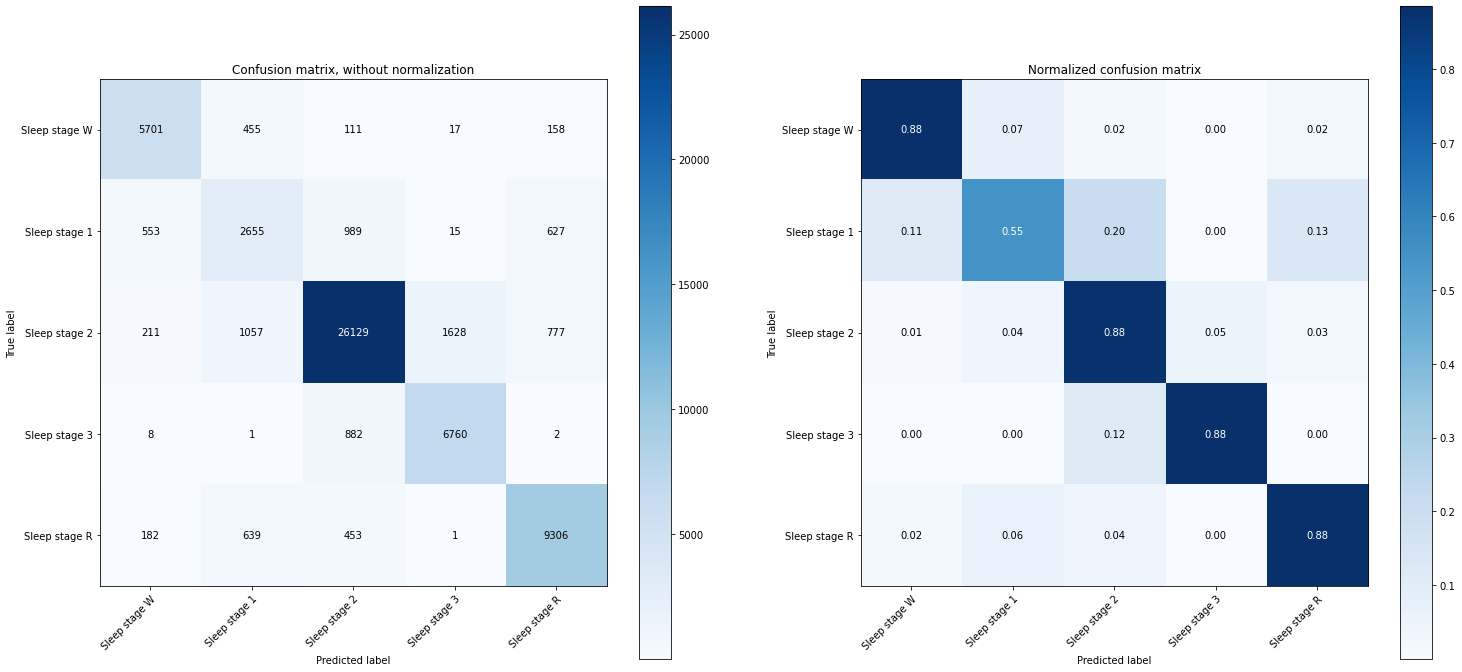

In [66]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

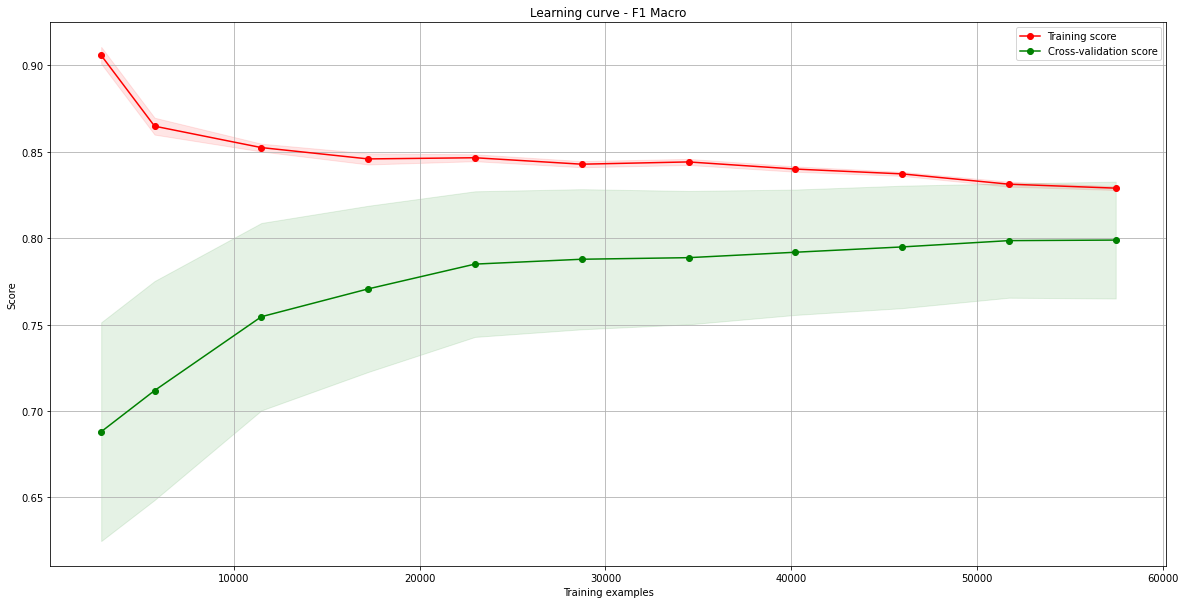

In [50]:
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.psg_file)
_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats[feat_cols],
    y=df_feats["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=20,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)

## The simple, catboost pipeline

In [46]:
### Create pipeline
from catboost import CatBoostClassifier
pipe = CatBoostClassifier(verbose=0, depth=5, n_estimators=2_000, random_state=0)

### Grouped 10-fold results for all the data

In [47]:
# Total of 10 folds
gkfold = StratifiedGroupKFold(n_splits=10)
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.psg_file)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    # n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [48]:
print("20-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

20-FOLD: TRAIN
  MACRO F1:           0.9063
  Balanced accuracy:  0.8938
  Accuracy:           0.9305
  Log loss:           0.1998


In [49]:
print("20-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))


20-FOLD: TEST
  MACRO F1:           0.815
  Balanced accuracy:  0.8069
  Accuracy:           0.8669
  Log loss:           0.3442


In [50]:
preds = []
preds_proba = []
y_trues = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test).ravel()]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

In [51]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.8172823869281292
ACC: 0.8671544413911695
KAPPA: 0.8026215468560806
LOG LOSS: 0.34376646960860113


In [52]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.51      0.62      0.56      3930
Sleep stage 2       0.92      0.89      0.91     30902
Sleep stage 3       0.84      0.88      0.86      7324
Sleep stage R       0.87      0.87      0.87     10586
Sleep stage W       0.91      0.89      0.90      6575

     accuracy                           0.87     59317
    macro avg       0.81      0.83      0.82     59317
 weighted avg       0.87      0.87      0.87     59317



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

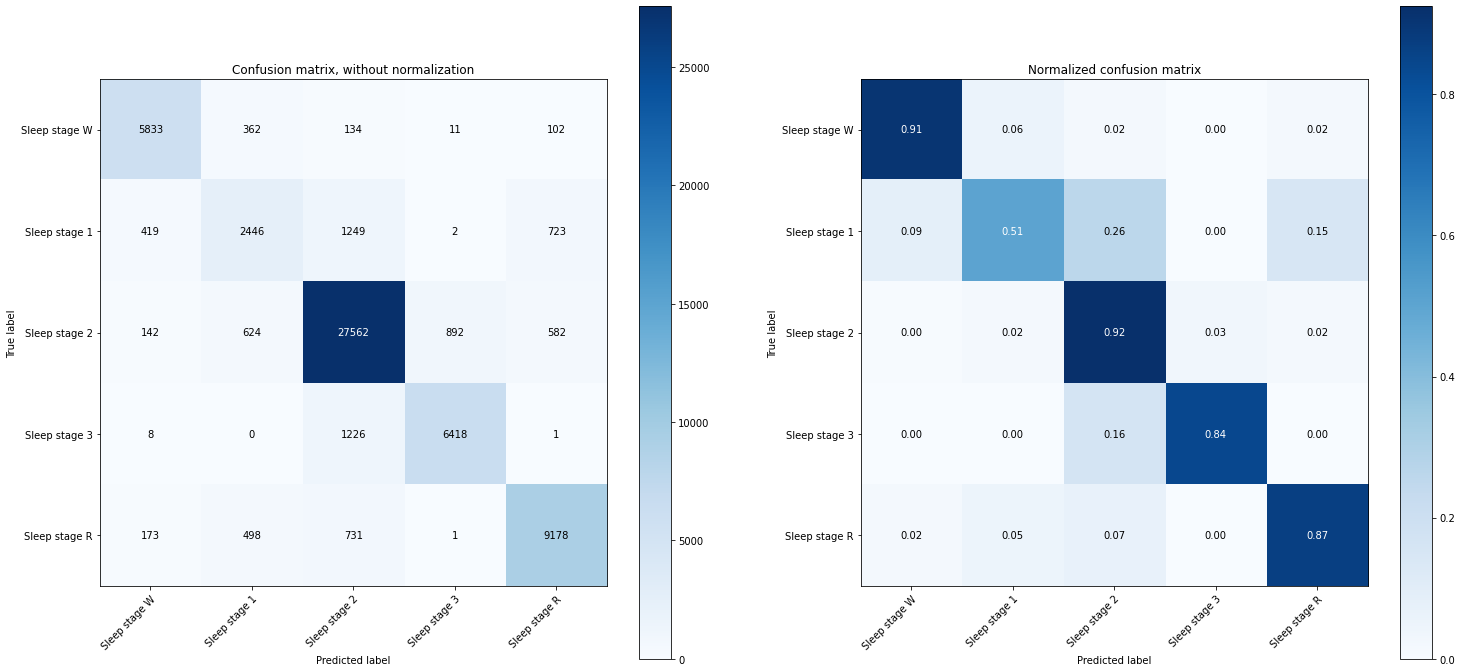

In [53]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

In [54]:
# cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.psg_file)
# _ = plot_learning_curve(
#     pipe,
#     title="Learning curve - F1 Macro",
#     X=df_feats[feat_cols],
#     y=df_feats["label"],
#     cv=cv,
#     scoring="f1_macro",
#     n_jobs=20,
#     train_sizes=[0.05] + list(np.linspace(0.1,1,10))
# )
